# Astrostats Assignment 2
## Supernova MH-MCMC exercise
### Indian Institute of Technology, Indore
##### Prasad Rajesh Posture (MSC2303121013)

In [1]:
# Importing the dependencies
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defining constant
c = 3*10**5 #(km/s) since Hubbles constant is given in km/s/Mpc

In [3]:
# Defining required functions
def a(z):
    return 1/(1+z)

def s(omega_m):
    return ((1-omega_m)/omega_m)**(1/3)

def eta(z,omega_m):
    # omega_m = np.clip(omega_m, 0.000001, 0.9999)
    return 2*np.sqrt((s(omega_m)**3)+1) * ((a(z)**(-4)) - 0.1540*(s(omega_m)*a(z)**(-3)) + 0.4304*((s(omega_m)/a(z))**2) + 0.19097*(s(omega_m)**3/(a(z)) + 0.066941*(s(omega_m)**4)))**(-1/8)

def D_L(z, omega_m, h):
    return (c*(1+z)/(100*h))*(eta(0,omega_m) - eta(z,omega_m))

def mu_th(z, omega_m, h):
    return 25 - 5*np.log10(h) + 5*np.log10(D_L(z, omega_m, h=1))

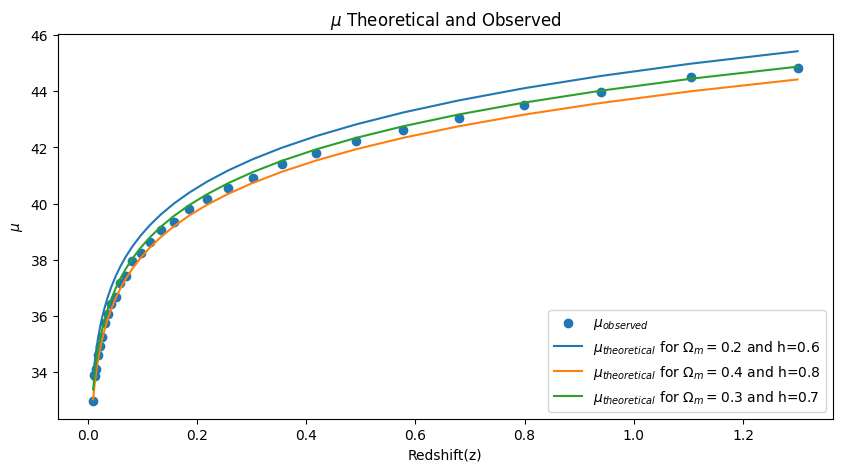

In [4]:
# Reading the data from the given files
data = np.genfromtxt('jla_mub_0.txt')
z = data[:,0]
mu_obs = data[:,1]
plt.figure(figsize=(10,5))
plt.scatter(z, mu_obs, label=r'$\mu_{observed}$')

# Plotted using different combinations of omega_m and h

mu_theoretial1 = mu_th(z=z,omega_m=0.2, h=0.6)
plt.plot(z, mu_theoretial1,label=r'$\mu_{theoretical}$ for $\Omega_m=0.2$ and h=0.6')

mu_theoretial2 = mu_th(z=z,omega_m=0.4, h=0.8)
plt.plot(z, mu_theoretial2,label=r'$\mu_{theoretical}$ for $\Omega_m=0.4$ and h=0.8')

mu_theoretial3 = mu_th(z=z,omega_m=0.3, h=0.7)
plt.plot(z, mu_theoretial3,label=r'$\mu_{theoretical}$ for $\Omega_m=0.3$ and h=0.7')

plt.legend()
plt.xlabel('Redshift(z)')
plt.ylabel(r'$\mu$')
plt.title(r"$\mu$ Theoretical and Observed")
plt.savefig('Trials.png')
plt.show()

It appears that the theoretical value of $\Omega_m$ and $h$ is closer to $0.3$ and $0.7$ respectively.

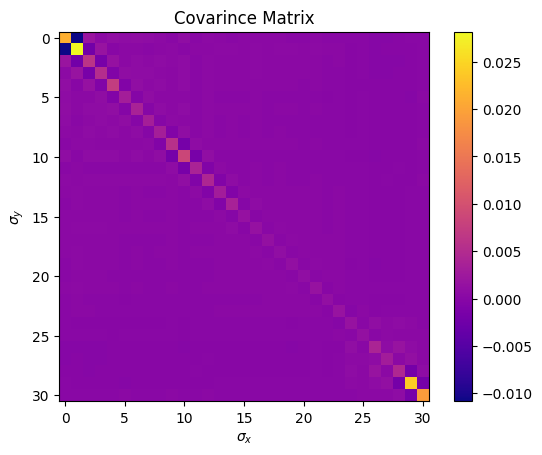

In [5]:
# Reading the covariant metrics
cov = np.genfromtxt('jla_mub_covmatrix.txt')
cov = cov.reshape(31,31)
inv_cov = np.linalg.inv(cov) #inverse of covariance matrix
plt.imshow(cov, cmap='plasma')
plt.colorbar()  # Add color bar indicating the scale
plt.title('Covarince Matrix')
plt.xlabel(r'$\sigma_x$')
plt.ylabel(r'$\sigma_y$')
plt.savefig('CovMatrix.png')
plt.show();

In [6]:
# Defining likelihood function
# All the likelihoods are taken in the logarithmic form
def likelihood(mu_obs,z , omega_m, h):
    mu_theoretical = mu_th(z, omega_m, h)
    diff_mu = mu_obs - mu_theoretical
    return (-1/2)*(np.dot(diff_mu, np.dot(inv_cov, diff_mu)))

In [7]:
# Defining parameters
SNb = 31
sample_n = 1000
param_n = 2

# Defining Metropolis-Hasting Algorithm
def MCMC_MH(omega_m_pre, h_pre):
    omega_m_nxt = np.abs(omega_m_pre + sigma_omega*np.random.randn())
    h_nxt = np.abs(h_pre + sigma_h*np.random.randn())

    pre_likelihood = likelihood(mu_obs, z, omega_m_pre, h_pre)
    nxt_likelihood = likelihood(mu_obs, z, omega_m_nxt, h_nxt)

    acceptance_ratio  = nxt_likelihood - pre_likelihood #Since taken log

    if np.log(np.random.normal(0,1))<acceptance_ratio:
        return omega_m_nxt, h_nxt, True
    else:
        return omega_m_pre, h_pre, False
    
# Doing MH-MCMC for different values of standard deviations in omega_m and h
def MCMC_MH_sigmas(sigma_omega, sigma_h):

    # Array to store the values
    h_values = [1]
    omega_m_values = [1]
    likelihood_values = []

    # Doing the random walk using the defined function
    for i in range(1, sample_n):
        omega_m_pre = omega_m_values[-1]
        h_pre = h_values[-1]
        omega_m_nxt, h_nxt, accepted = MCMC_MH(omega_m_pre, h_pre)

        if accepted:
            omega_m_values.append(omega_m_nxt)
            h_values.append(h_nxt)

            likelihood_values.append(likelihood(mu_obs, z, omega_m_nxt, h_nxt))
    
    return h_values, omega_m_values, likelihood_values

# Plotting the chain obtained during the random walk
# Along with the observed and theoretical values of distance modulus using the average values of parameters obtained
def plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean):
    # Plot of Random Walker Chain
    plt.scatter(omega_m_values[1:], h_values[1:], c=likelihood_values, cmap="BuPu")
    plt.ylabel("h")
    plt.xlabel(r"$\Omega_m$")
    plt.title("Random Walk of MH-MCMC")
    plt.colorbar(label='likelihood')
    plt.savefig(f'RandomWalk{str(sigma_omega)}.png')
    plt.show()
    # Comparative plot of
    plt.figure(figsize=(10,5))
    plt.scatter(z, mu_obs, label=r'$\mu_{observed}$')

    # Plotting with 
    mu_theoretical= mu_th(z=z,omega_m=omega_m_mean, h=h_mean)
    plt.plot(z, mu_theoretical,label=r'$\mu_{theoretical}$', color='r')
    plt.legend()
    plt.xlabel('Redshift(z)')
    plt.ylabel(r'$\mu$')
    plt.title(f"Plot of Distance Modulus with $\Omega_m$:{round(omega_m_mean,3)}, h:{round(h_mean,3)}")
    plt.savefig(f'MCMC{str(sigma_omega)}.png')
    plt.show()

    # Root Mean Square Error to Estimate the difference between observed values and theoretical values given by the set of parameters
    # It helps us with parameters which are closer and give plot that can't directly be differentiated
    print("RMSE:",np.sqrt(np.mean((mu_obs-mu_theoretical)**2)))


# Standard Deviation as 0.001 in $\Omega_m $ and $h$ 

Acceptance Ratio:25.8%
Burned Points: 129
Average Value of Matter Density: 0.970686416505556
Average Value of Hubble Scaling Factor: 0.8592196178409539
Variance in Matter Density: 1.069742954807128e-05
Variance in Hubble Scaling Factor: 0.0007890696792403237
Covariance in Both Paramaters: 7.805717672531185e-05


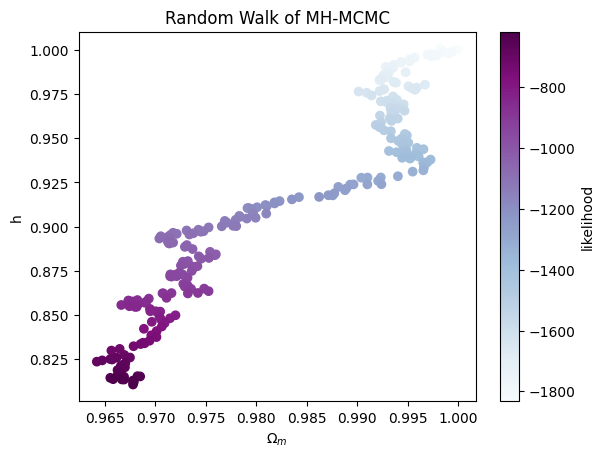

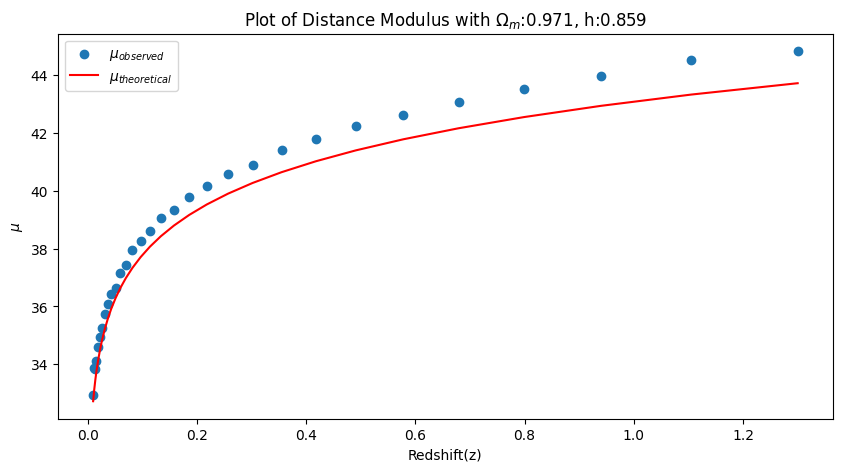

RMSE: 0.6789533348111245


In [8]:
# Assigning sigma values
sigma_omega = 0.001
sigma_h = 0.001

# Calculating the parameters usingthe MH-MCMC algorithm
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)

# Acceptance Ratio
print(f"Acceptance Ratio:{len(h_values)/10}%")

# Burning the points which are far away from the expected distribution
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)

# Using parameter values post burning to calculate different statistics
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
# Averages
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)

# Variance and Covariance
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

# Standard Deviation as 0.01 in $\Omega_m $ and $h$ 

Burned Points: 110
Average Value of Matter Density: 0.3379002717965791
Average Value of Hubble Scaling Factor: 0.7450004235412014
Acceptance Ratio:22.1%
Variance in Matter Density: 0.016987384981450037
Variance in Hubble Scaling Factor: 0.0018403362936758203
Covariance in Both Paramaters: -0.0055020110787437765


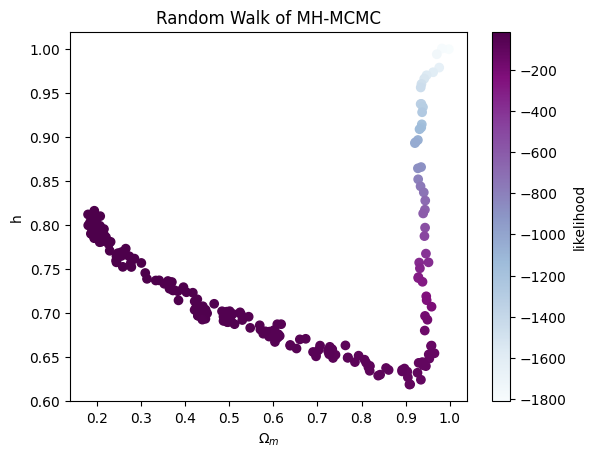

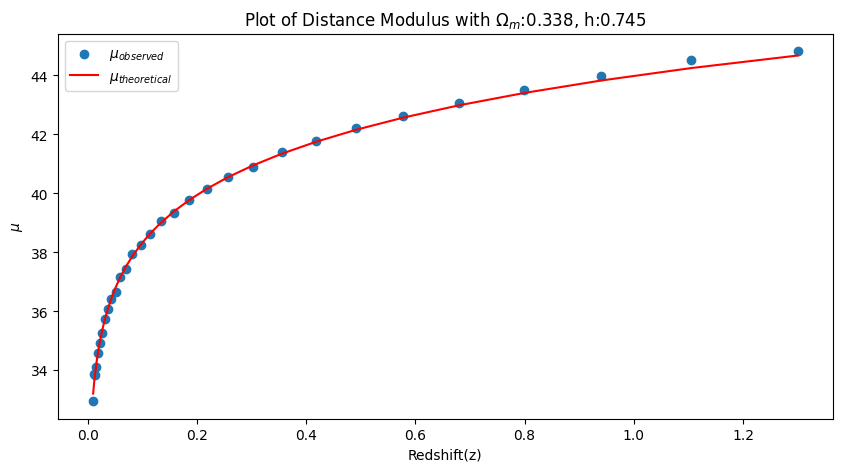

RMSE: 0.10927391156175172


In [9]:
sigma_omega = 0.01
sigma_h = 0.01
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

# Standard Deviation as 0.1 in $\Omega_m $ and $h$ 

Burned Points: 16
Average Value of Matter Density: 0.2114166773978515
Average Value of Hubble Scaling Factor: 0.7968681678458296
Acceptance Ratio:3.1%
Variance in Matter Density: 0.005150387421269451
Variance in Hubble Scaling Factor: 0.0013308014846238373
Covariance in Both Paramaters: -0.0026231864893593616


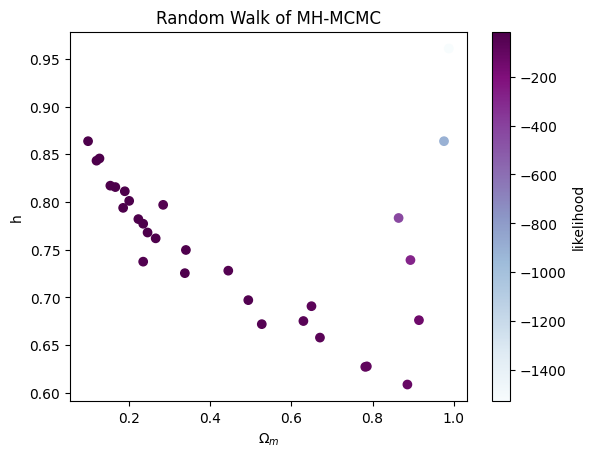

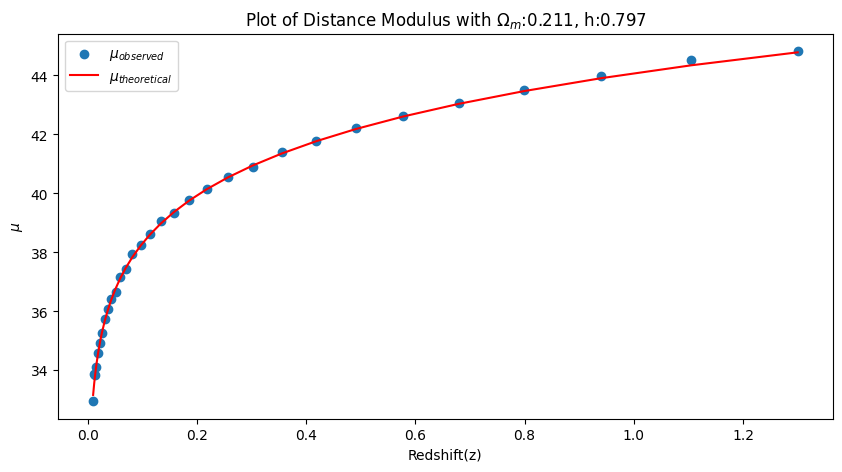

RMSE: 0.0906276444880421


In [10]:
sigma_omega = 0.1
sigma_h = 0.1
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

# Standard Deviation as 1.0 in $\Omega_m $ and $h$ 

Burned Points: 2
Average Value of Matter Density: 0.17463436471211743
Average Value of Hubble Scaling Factor: 0.9427443469563935
Acceptance Ratio:0.5%
Variance in Matter Density: 0.015680782980303933
Variance in Hubble Scaling Factor: 0.033850525457630704
Covariance in Both Paramaters: -0.02563787955921188


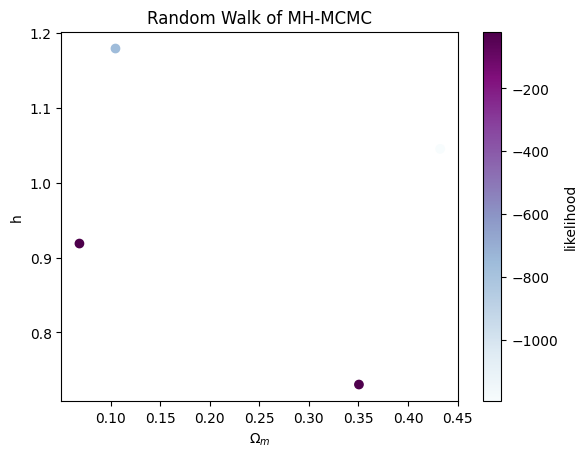

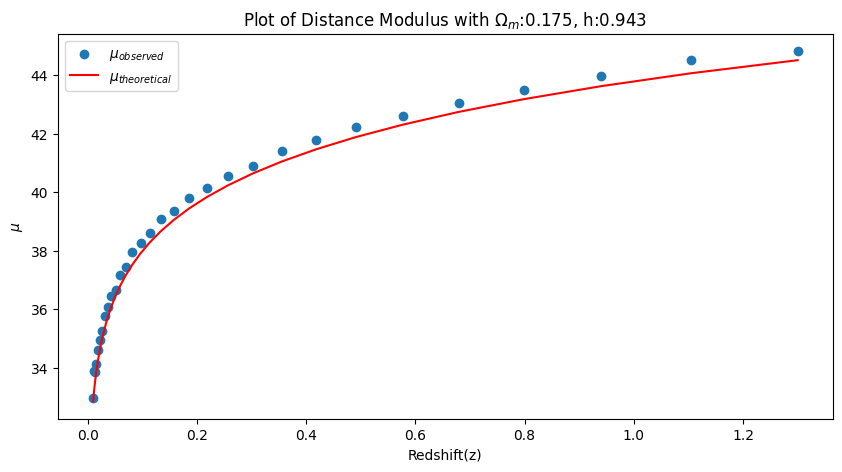

RMSE: 0.34123541205959246


In [11]:
sigma_omega = 1.0
sigma_h = 1.0
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

# Standard Deviation as 10.0 in $\Omega_m $ and $h$ 

Burned Points: 2
Average Value of Matter Density: 0.2419740544043847
Average Value of Hubble Scaling Factor: 0.8677678535301768
Acceptance Ratio:0.3%
Variance in Matter Density: 0.0
Variance in Hubble Scaling Factor: 0.0
Covariance in Both Paramaters: nan


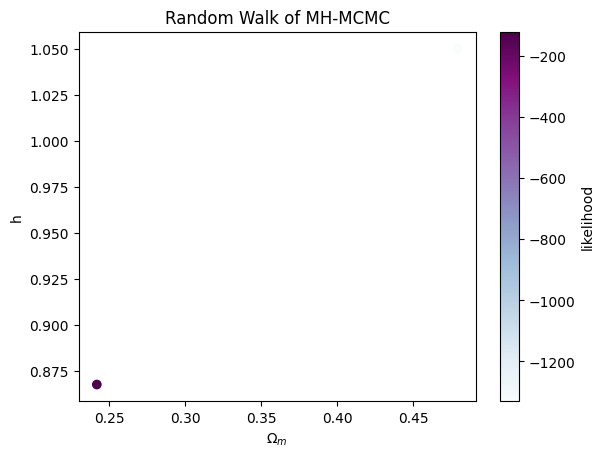

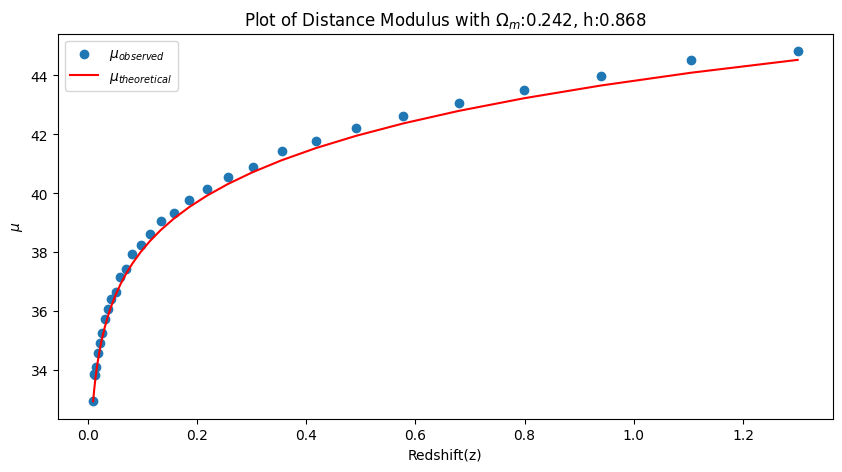

RMSE: 0.2613811697018982


In [12]:
sigma_omega = 10.0
sigma_h = 10.0
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

# Standard Deviation as 100.0 in $\Omega_m $ and $h$ 

Burned Points: 0
Average Value of Matter Density: 1.0
Average Value of Hubble Scaling Factor: 1.0
Acceptance Ratio:0.1%
Variance in Matter Density: 0.0
Variance in Hubble Scaling Factor: 0.0
Covariance in Both Paramaters: nan


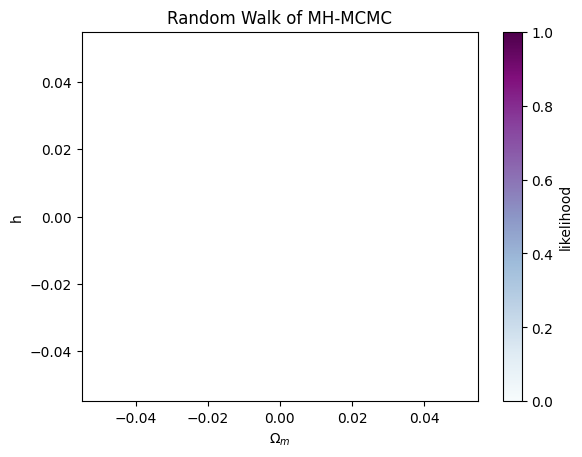

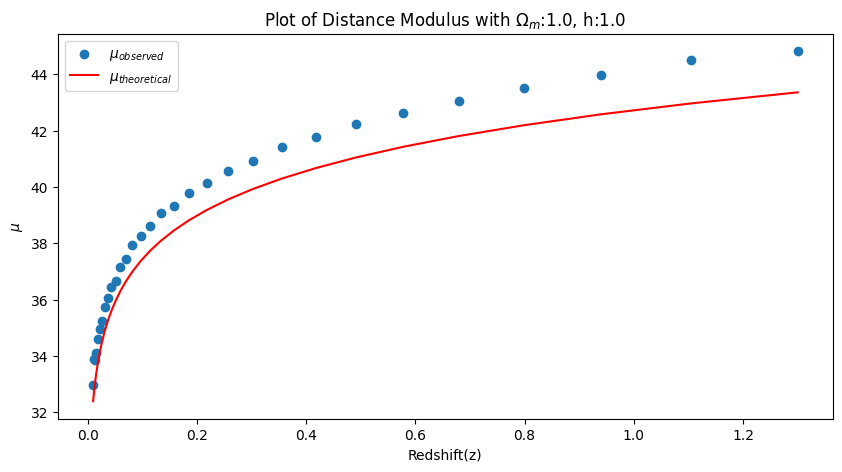

RMSE: 1.0078872911741166


In [13]:
sigma_omega = 100.0
sigma_h = 100.0
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

# Inferences
#### Size of the proposal distribution
1) For smaller size of the proposal distribution, the algorithm explores the state space more locally. It focuses on exploring the immediate vicinity of the current state rather than making large jumps to distant regions, hence the actual target distribution may not be explored at all.
2) For larger size of the proposal distribution, the parameters space is explored widely but the acceptance ratio is very low hence very few points (almost negligible) are accepted from the proposed distribution, hence it gives slower convergence.

#### Acceptance Ratio
1) The acceptance ratio decreases as we increase the size of the proposal distribution, because when the size of the proposal distribution is increased, it entails making more extensive jumps in the state space. These larger jumps may result in candidate samples that deviate further from the current state. Consequently, there's a decreased likelihood of accepting these proposed moves due to potential misalignment with the target distribution, leading to a decrease in the acceptance ratio.
2) The acceptance ratio increases as we decrease the size of the proposal distribution, because when you reduce the size of the proposal distribution, you're effectively opting for smaller jumps in the state space. These more restrained movements tend to keep candidate samples closer to the current state. As these movements are closer, they are more likely to align with the target distribution, resulting in a higher acceptance ratio.

# Statistics of Reasonable Proposal Distribution
From the above plots and calculations for different sizes of proposal distributions, and the RMSE calculations done using the mean values of parameters obtained, it is evident that the reasonable proposal distribution is obtained by setting $\sigma_{\Omega_{m}}=0.01$ and $\sigma_{h}=0.01$ but we get good accuracy with observations at $\sigma_{\Omega_{m}}=0.1$ and $\sigma_{h}=0.1$ . Hence, we will take the logarithmic mean of both which gives us $\sigma_{\Omega_{m}}=0.0316$ and $\sigma_{h}=0.0316$.

Burned Points: 52
Average Value of Matter Density: 0.16188631998084008
Average Value of Hubble Scaling Factor: 0.8206422907369247
Acceptance Ratio:10.4%
Variance in Matter Density: 0.0012766122594142634
Variance in Hubble Scaling Factor: 0.0007148594945586028
Covariance in Both Paramaters: -0.0009207402517061586


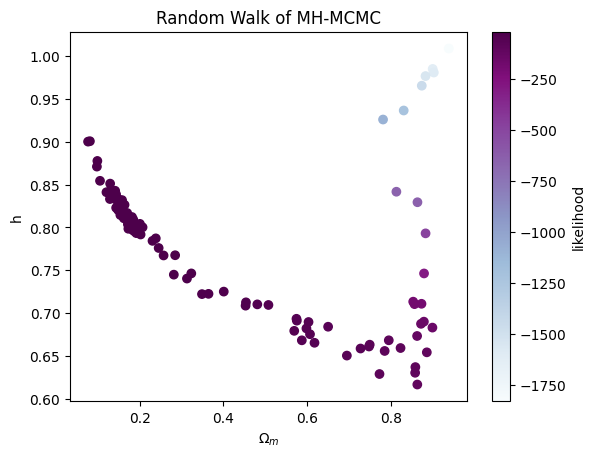

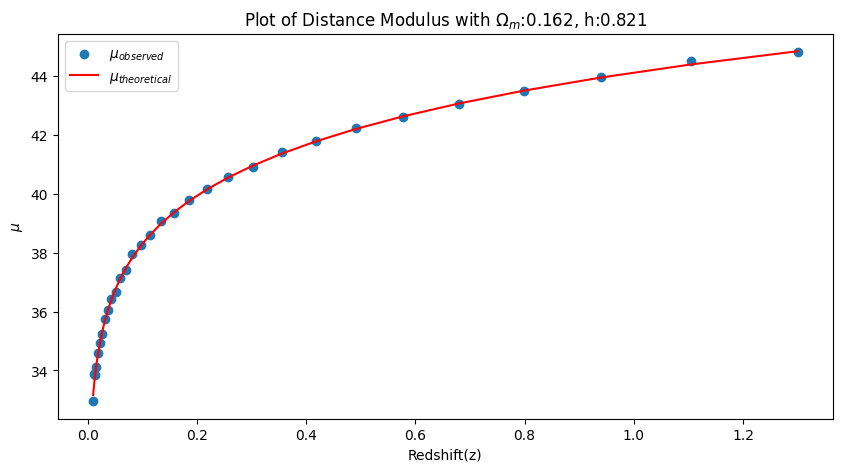

RMSE: 0.08574169437799625


In [14]:
sigma_omega = 0.0316
sigma_h = 0.0316
h_values, omega_m_values, likelihood_values = MCMC_MH_sigmas(sigma_omega, sigma_h)
burned = round(5*(len(h_values))/10)
print("Burned Points:",burned)
omega_post_burning = omega_m_values[burned:]
h_post_burning = h_values[burned:]
omega_m_mean = np.mean(omega_post_burning)
print("Average Value of Matter Density:", omega_m_mean)
h_mean = np.mean(h_post_burning)
print("Average Value of Hubble Scaling Factor:", h_mean)
print(f"Acceptance Ratio:{len(h_values)/10}%")
print("Variance in Matter Density:",np.var(omega_post_burning))
print("Variance in Hubble Scaling Factor:", np.var(h_post_burning))
print("Covariance in Both Paramaters:",np.cov(omega_post_burning, h_post_burning)[0,1])
plotter(h_values, omega_m_values, likelihood_values, omega_m_mean, h_mean)

Note: The statistics keep on changing after re-execution, the reported ones are from the last execution of the code.

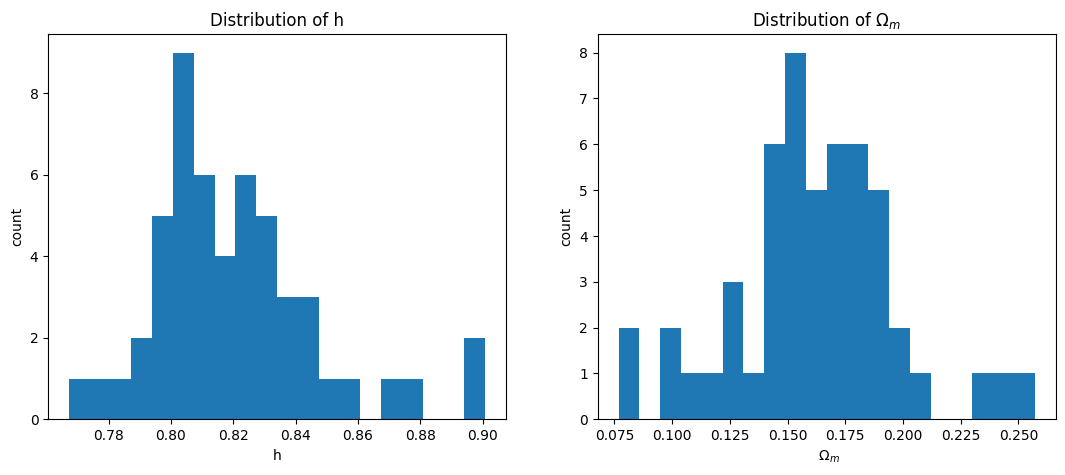

In [30]:
fig, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].hist(h_post_burning, bins=20)
axes[0].set_title('Distribution of h')
axes[0].set_xlabel('h')
axes[0].set_ylabel('count')
axes[1].hist(omega_post_burning, bins=20)
axes[1].set_title(f'Distribution of $\Omega_m$')
axes[1].set_xlabel(f' $\Omega_m$')
axes[1].set_ylabel('count')
plt.savefig('distribution.png');

The End